In [141]:
from create_model import data_gathering_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
import tensorflowjs as tfjs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Collect, visualize and process data

In [2]:
data = data_gathering_pipeline()
df = pd.DataFrame(data)

df

,weekday,hour,minute,timestamp,n_carros,temperature,weather_condition
0,1,19,14,2023-05-16 19:14:47.232901,8,20.0,Sunny
1,1,19,20,2023-05-16 19:20:01.271561,13,21.0,Sunny
2,1,19,25,2023-05-16 19:25:13.774136,13,21.0,Sunny
3,1,19,30,2023-05-16 19:30:26.469829,13,21.0,Sunny
4,1,19,35,2023-05-16 19:35:39.685086,12,21.0,Sunny
...,...,...,...,...,...,...,...
1858,6,19,36,2023-05-21 19:36:53.114320,8,20.0,Sunny
1859,6,19,40,2023-05-21 19:40:05.414656,9,20.0,Sunny
1860,6,19,43,2023-05-21 19:43:18.063494,8,20.0,Sunny
1861,6,19,46,2023-05-21 19:46:30.505655,8,20.0,Sunny


In [21]:
df.describe()

,weekday,hour,minute,n_carros,temperature
count,1863.000000,1863.000000,1863.000000,1863.000000,1863.000000
mean,3.861514,11.994632,29.563607,7.971014,19.006602
std,1.455806,6.235873,17.230980,4.820764,2.897036
min,1.000000,0.000000,0.000000,0.000000,10.400000
25%,3.000000,7.000000,15.000000,4.000000,17.000000
50%,4.000000,12.000000,30.000000,10.000000,19.000000
75%,5.000000,17.000000,44.000000,12.000000,21.000000
max,6.000000,23.000000,59.000000,14.000000,24.000000


<AxesSubplot:xlabel='weather_condition', ylabel='Count'>

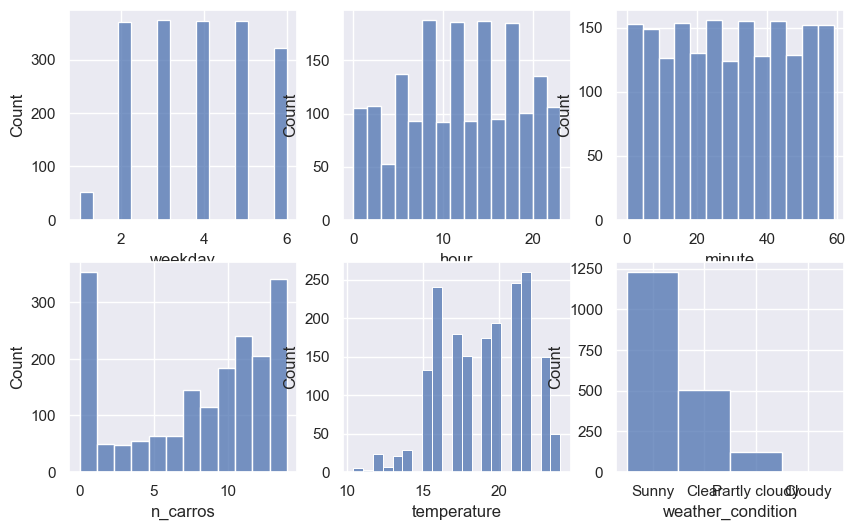

In [20]:
sns.set(rc={'figure.figsize':(10, 6)})
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.histplot(df.weekday, ax=axs[0][0])
sns.histplot(df.hour, ax=axs[0][1])
sns.histplot(df.minute, ax=axs[0][2])
sns.histplot(df.n_carros, ax=axs[1][0])
sns.histplot(df.temperature, ax=axs[1][1])
sns.histplot(df.weather_condition, ax=axs[1][2])

<AxesSubplot:xlabel='timestamp', ylabel='n_carros'>

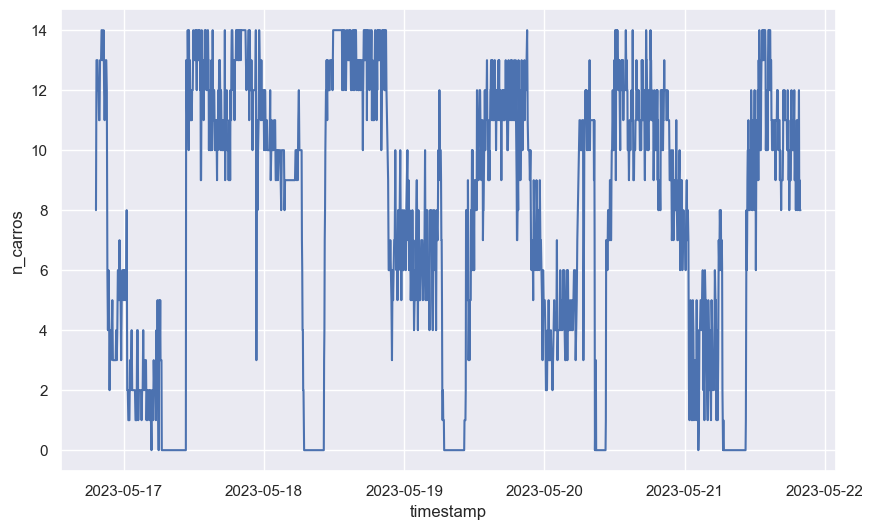

In [4]:
sns.set(rc={'figure.figsize':(10, 6)})
sns.lineplot(data=df, x="timestamp", y="n_carros")

<AxesSubplot:xlabel='hour', ylabel='n_carros'>

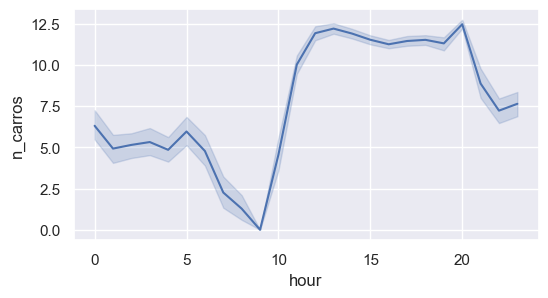

In [49]:
sns.set(rc={'figure.figsize':(6, 3)})
sns.lineplot(data=df, x="hour", y="n_carros")


Entre as 21h e as 11h, a contagem é mais imprecisa. Isto deve-se ao facto de ser de noite e haver pouca luminosidade, e ao nascer do sol haver um reflexo no vidro que faz que com o modelo não consiga fazer tão bem as deteções.

Para o treino do modelo estes valores têm de ser corrigidos. Para isso vão fazer substituídos pela media da lotação do estacionamento durante as 3 horas do dia.

In [50]:
df_processed = df.copy()

for i in range(1, 7):
    df_processed.loc[(df_processed['weekday'] == i) & ((df_processed['hour'] >= 21) | (df_processed['hour'] <= 10)), 'n_carros'] = int(df_processed.loc[(df_processed['weekday'] == i) & (df_processed['hour'] >= 19) & (df_processed['hour'] <= 21), 'n_carros'].mean())

<AxesSubplot:xlabel='hour', ylabel='n_carros'>

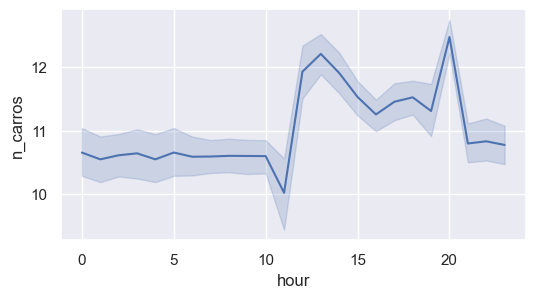

In [51]:
sns.set(rc={'figure.figsize':(6, 3)})
sns.lineplot(data=df_processed, x="hour", y="n_carros")

In [52]:
df_processed.describe()

,weekday,hour,minute,n_carros,temperature
count,1863.000000,1863.000000,1863.000000,1863.000000,1863.000000
mean,3.861514,11.994632,29.563607,11.088030,19.006602
std,1.455806,6.235873,17.230980,1.671709,2.897036
min,1.000000,0.000000,0.000000,3.000000,10.400000
25%,3.000000,7.000000,15.000000,10.000000,17.000000
50%,4.000000,12.000000,30.000000,11.000000,19.000000
75%,5.000000,17.000000,44.000000,13.000000,21.000000
max,6.000000,23.000000,59.000000,14.000000,24.000000


<AxesSubplot:xlabel='timestamp', ylabel='n_carros'>

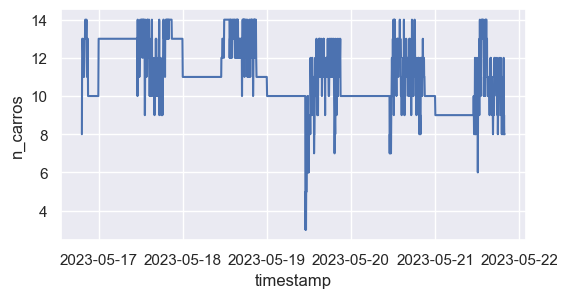

In [53]:
sns.lineplot(data=df_processed, x="timestamp", y="n_carros")

Existem alguns outliers. Estes seram detetados através da técnica IQR e substituídos pela média.

<AxesSubplot:>

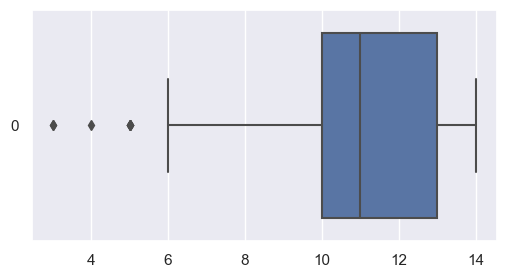

In [54]:
sns.set(rc={'figure.figsize':(6, 3)})
sns.boxplot(data=df_processed.n_carros, orient='h')

In [56]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

def impute_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   upper = df[~(df>(q3+1.5*IQR))].max()
   lower = df[~(df<(q1-1.5*IQR))].min()

   df = np.where(df > upper,
       df.mean(),
       np.where(
           df < lower,
           df.mean(),
           df
           )
       )

   return df

df_processed['n_carros'] = impute_outliers_IQR(df_processed['n_carros'])


<AxesSubplot:>

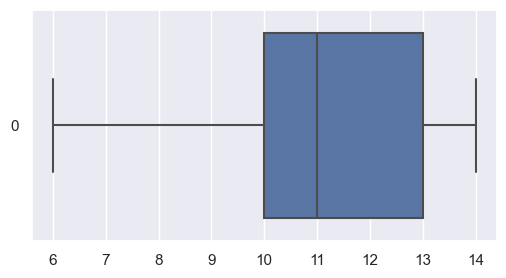

In [57]:
sns.set(rc={'figure.figsize':(6, 3)})
sns.boxplot(data=df_processed.n_carros, orient='h')

# Train Model

In [62]:
dataset = df_processed.copy()
dataset.loc[(dataset['weather_condition'] != "Rainy"), 'weather_condition'] = 1
dataset.loc[(dataset['weather_condition'] == "Rainy"), 'weather_condition'] = 0
dataset['weather_condition'] = pd.to_numeric(dataset["weather_condition"])
dataset

,weekday,hour,minute,timestamp,n_carros,temperature,weather_condition
0,1,19,14,2023-05-16 19:14:47.232901,8.0,20.0,1
1,1,19,20,2023-05-16 19:20:01.271561,13.0,21.0,1
2,1,19,25,2023-05-16 19:25:13.774136,13.0,21.0,1
3,1,19,30,2023-05-16 19:30:26.469829,13.0,21.0,1
4,1,19,35,2023-05-16 19:35:39.685086,12.0,21.0,1
...,...,...,...,...,...,...,...
1858,6,19,36,2023-05-21 19:36:53.114320,8.0,20.0,1
1859,6,19,40,2023-05-21 19:40:05.414656,9.0,20.0,1
1860,6,19,43,2023-05-21 19:43:18.063494,8.0,20.0,1
1861,6,19,46,2023-05-21 19:46:30.505655,8.0,20.0,1


In [60]:
train_rows = df.sample(frac = 0.9)
df_train = dataset.iloc[train_rows.index]
df_test = dataset.drop(df_train.index, axis=0)

print(df_train.shape, df_test.shape)

(1677, 7) (186, 7)


In [64]:
X, y = dataset.drop(['n_carros', 'timestamp'], axis=1), dataset.n_carros

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85)
X_train, y_train

(      weekday  hour  minute  temperature  weather_condition
 759         3    20      40         20.0                  1
 801         4     0      27         17.0                  1
 745         3    19      55         21.0                  1
 479         3     5      18         16.0                  1
 217         2    11      32         20.0                  1
 ...       ...   ...     ...          ...                ...
 1243        5     6      42         16.0                  1
 335         2    17      56         23.0                  1
 195         2    10      21         18.0                  1
 1835        6    18      23         21.0                  1
 1244        5     6      46         16.0                  1
 
 [279 rows x 5 columns],
 759     14.0
 801     10.0
 745     13.0
 479     11.0
 217     11.0
         ... 
 1243    10.0
 335      9.0
 195     13.0
 1835    10.0
 1244    10.0
 Name: n_carros, Length: 279, dtype: float64)

In [170]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(X.keys())]),
    keras.layers.Dense(32, activation='relu'),
    # keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='relu')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(0.0003),
            loss='mse',
            metrics=['mae', 'mse'])

model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 64)                384       
                                                                 
 dense_101 (Dense)           (None, 32)                2080      
                                                                 
 dense_102 (Dense)           (None, 16)                528       
                                                                 
 dense_103 (Dense)           (None, 1)                 17        
                                                                 
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


In [171]:
history = model.fit(X_train, y_train, epochs=200)

preds = model.predict(X_test)
mean_absolute_error(y_test, preds), mean_squared_error(y_test, preds)

Epoch 1/200
9/9 [==============================] - 2s 4ms/step - loss: 86.6640 - mae: 9.0933 - mse: 86.6640
Epoch 2/200
9/9 [==============================] - 0s 3ms/step - loss: 54.0492 - mae: 7.0764 - mse: 54.0492
Epoch 3/200
9/9 [==============================] - 0s 4ms/step - loss: 32.6783 - mae: 5.3428 - mse: 32.6783
Epoch 4/200
9/9 [==============================] - 0s 3ms/step - loss: 18.1808 - mae: 3.7056 - mse: 18.1808
Epoch 5/200
9/9 [==============================] - 0s 4ms/step - loss: 10.0419 - mae: 2.5247 - mse: 10.0419
Epoch 6/200
9/9 [==============================] - 0s 3ms/step - loss: 7.6701 - mae: 2.1736 - mse: 7.6701
Epoch 7/200
9/9 [==============================] - 0s 2ms/step - loss: 7.0223 - mae: 2.0635 - mse: 7.0223
Epoch 8/200
9/9 [==============================] - 0s 4ms/step - loss: 6.6574 - mae: 2.0230 - mse: 6.6574
Epoch 9/200
9/9 [==============================] - 0s 3ms/step - loss: 6.2931 - mae: 1.9628 - mse: 6.2931
Epoch 10/200
9/9 [==================

(1.171096265337662, 2.1545421572962407)

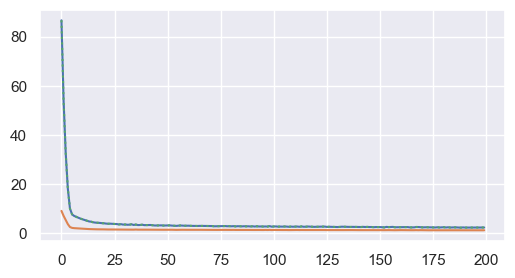

In [172]:
plt.plot(history.history['mse'])
plt.plot(history.history['mae'])
plt.plot(history.history['loss'], linestyle = 'dotted')
plt.show()

<AxesSubplot:ylabel='Count'>

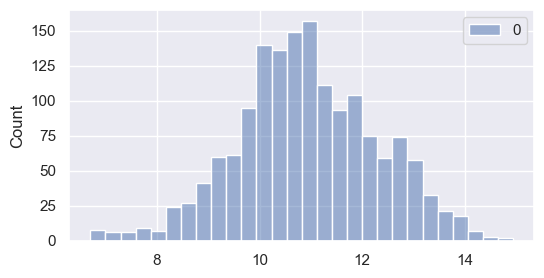

In [173]:
sns.histplot(preds)

In [174]:
X_test.iloc[0], y_test.iloc[0], preds[0]

(weekday               6.0
 hour                 14.0
 minute               35.0
 temperature          22.0
 weather_condition     1.0
 Name: 1764, dtype: float64,
 14.0,
 array([10.542686], dtype=float32))

In [175]:
X_test.iloc[0].values, model.predict(np.array([X_test.iloc[0].values]))

1/1 [==============================] - 0s 96ms/step


(array([ 6., 14., 35., 22.,  1.]), array([[10.542686]], dtype=float32))

In [176]:
tfjs.converters.save_keras_model(model, './models/modelv4')